### 🛠️ Step 0: 初期設定と環境準備

このステップでは、ノートブックの先頭で行う共通設定をまとめます。  
学習対象のパラメータをループで処理するため、`TARGET_COLS` を定義し、画像サイズ・学習回数・保存先などを初期化しておきます。

#### 💡 含まれる内容：
- 使用パラメータリスト（dipCount / hue_cos / hue_sin / circleCount）
- 学習用ハイパーパラメータ（バッチサイズ、エポック数など）
- val_loss 測定の繰り返し回数（`REPEAT`）
- 保存ファイル（`val_losses.json`）のパスと初期読み込み

#### 🔥 ポイント：
- `val_losses.json` は存在すれば読み込み、なければ空辞書で初期化
- 後続のロス記録で `.append()` していくため、リスト形式で持つ

In [16]:
# === ライブラリ読み込み ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# === 対象パラメータ ===
TARGET_COLS = ["dipCount", "hue_cos", "hue_sin", "circleCount"]

# === ハイパーパラメータ ===
IMAGE_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
REPEAT = 8  # 各パラメータごとの val_loss 測定回数（例：10）

# === パス定義 ===
DATA_DIR = Path("../../data/circle-stroke")
CSV_PATH = DATA_DIR / "metadata.csv"
IMG_DIR = DATA_DIR / "images"

VAL_LOSS_PATH = Path("../../loss_stats/val_losses.json")

# === デバイス設定（Mac対応）===
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# === val_losses.json の読み込み or 初期化 ===
if VAL_LOSS_PATH.exists():
    with open(VAL_LOSS_PATH, "r") as f:
        val_losses = json.load(f)
else:
    val_losses = {}

# === リスト形式にしておく（初期化）===
for col in TARGET_COLS:
    if col not in val_losses:
        val_losses[col] = []

✅ Using device: mps


### 🧮 Step 1: CSV読み込みと対象データの抽出

このステップでは、画像とパラメータ情報が記載された `metadata.csv` を読み込み、  
画像ファイルとマッチするデータのみを抽出します。単体学習でもマルチ学習と同じデータ構成にするため、  
共通のCSVと画像ディレクトリを使用します。

#### 💡 含まれる処理：
- `metadata.csv` を読み込み
- `TARGET_COLS` に含まれるすべてのパラメータを含む行のみ抽出
- 画像ファイルの存在確認
- ファイルパス列の追加

In [17]:
# === CSV読み込み ===
df = pd.read_csv(CSV_PATH)

# id + ターゲット列のみ抽出
df_targets = df[["id"] + ["dipCount", "hue", "circleCount"]].copy()

# ファイル名・パス列を追加
df_targets["filename"] = df_targets["id"].apply(lambda x: f"image_{x}.png")
df_targets["filepath"] = df_targets["filename"].apply(lambda x: IMG_DIR / x)

# 実在する画像ファイルだけにフィルタリング
df_targets = df_targets[df_targets["filepath"].apply(lambda x: x.exists())].reset_index(drop=True)

# チェック
print(f"✅ 使用可能なデータ数: {len(df_targets)}")
df_targets.head()

✅ 使用可能なデータ数: 999


,id,dipCount,hue,circleCount,filename,filepath
0,20250521_0001,3,326.0,1444,image_20250521_0001.png,../../data/circle-stroke/images/image_20250521...
1,20250521_0002,5,10.2,718,image_20250521_0002.png,../../data/circle-stroke/images/image_20250521...
2,20250521_0003,3,69.9,1149,image_20250521_0003.png,../../data/circle-stroke/images/image_20250521...
3,20250521_0004,5,342.1,773,image_20250521_0004.png,../../data/circle-stroke/images/image_20250521...
4,20250521_0005,9,349.5,1092,image_20250521_0005.png,../../data/circle-stroke/images/image_20250521...


### 🧾 Step 2: 単体パラメータ用 Dataset クラスの定義

このステップでは、画像と単一のパラメータを対応付けた PyTorch Dataset を定義します。  
`TARGET_COLS` をループで回す前提なので、**引数で対象パラメータを指定**できるようにしておきます。

#### 💡 含まれる構成：

- `SingleParamDataset` クラス
- 指定した `target_col` のみをラベルとして抽出
- Transform 付きの画像前処理（Resize → ToTensor）

In [18]:
class SingleParamDataset(Dataset):
    def __init__(self, df, img_dir, target_col, image_size=128):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.target_col = target_col
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 画像読み込み
        image = Image.open(row["filepath"]).convert("RGB")
        image = self.transform(image)

        # ラベル取得（float型）
        if self.target_col == "hue_cos":
            hue_rad = np.deg2rad(row["hue"])
            label = np.cos(hue_rad)
        elif self.target_col == "hue_sin":
            hue_rad = np.deg2rad(row["hue"])
            label = np.sin(hue_rad)
        else:
            label = row[self.target_col]

        return image, torch.tensor(label, dtype=torch.float32)

### 📦 Step 3: train/val 分割と DataLoader 構築

このステップでは、前処理済みの `df_targets` を訓練・検証用に分割し、  
指定された `target_col` に対して `SingleParamDataset` を使って DataLoader を構築します。  
この処理は `REPEAT` ループの中で何度も使うため、関数化しておくと便利です。

#### 💡 含まれる処理：

- `train_test_split` による 80:20 分割
- Dataset / DataLoader の作成
- 1回の呼び出しでバッチ学習ができる構造に整理

In [19]:
from sklearn.model_selection import train_test_split

def create_dataloaders(df, target_col):
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=random.randint(0, 9999))

    train_dataset = SingleParamDataset(df_train, IMG_DIR, target_col, image_size=IMAGE_SIZE)
    val_dataset = SingleParamDataset(df_val, IMG_DIR, target_col, image_size=IMAGE_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

### 🧠 Step 4: 単一出力用 CNN モデルの定義

このステップでは、各パラメータを1つずつ回帰するための、**1出力のCNNモデル** を定義します。  
複雑な構造は必要なく、v2/v3と同じ構成の簡略版で十分です。

#### 💡 含まれる内容：

- 入力：RGB画像（3×128×128）
- 出力：1次元の回帰値（1ユニット）
- `SingleParamCNN` クラスとして定義し、毎回インスタンス化

In [20]:
class SingleParamCNN(nn.Module):
    def __init__(self, image_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        flatten_size = 32 * (image_size // 4) * (image_size // 4)
        self.fc1 = nn.Linear(flatten_size, 64)
        self.fc2 = nn.Linear(64, 1)  # 出力1ユニット（単一回帰）

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze(1)  # shape: (B,) にする

### 🏋️‍♀️ Step 5: 学習と val_loss の測定（REPEAT対応）

このステップでは、`REPEAT` 回数に応じて学習を複数回実行し、各回の val_loss を測定します。  
1回ごとにモデルを再初期化し、train/val をランダムに分割して実施することで、  
安定した性能指標を得られるようにします。

#### 💡 含まれる処理：

- ループで REPEAT 回学習
- 各回の val_loss をリストに記録
- tqdm による進捗表示つき

In [21]:
def train_and_evaluate(target_col, repeat=1):
    losses = []

    for i in tqdm(range(repeat), desc=f"🎯 {target_col}"):
        train_loader, val_loader = create_dataloaders(df_targets, target_col)

        model = SingleParamCNN(image_size=IMAGE_SIZE).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # --- 学習ループ ---
        model.train()
        for epoch in range(NUM_EPOCHS):
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # --- 検証ループ ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        losses.append(avg_val_loss)

    return losses

### 💾 Step 6: val_losses.json への追記と保存

このステップでは、各パラメータに対する `val_loss` リストを `val_losses.json` に追記保存します。  
既存データがあれば `.extend()`、なければ新規キーを追加する設計です。

#### 💡 含まれる処理：

- 各パラメータの `val_loss` リストを記録
- JSONの既存データに `.extend()` で追記
- 保存は `indent=2` 付きで整形

In [22]:
# === 全パラメータを順に処理して val_loss を記録 ===
for target_col in TARGET_COLS:
    print(f"🔁 {target_col} を {REPEAT} 回学習して val_loss 測定中...")
    new_losses = train_and_evaluate(target_col, repeat=REPEAT)

    if target_col in val_losses:
        val_losses[target_col].extend(new_losses)
    else:
        val_losses[target_col] = new_losses

# === 保存（追記型）===
VAL_LOSS_PATH.parent.mkdir(parents=True, exist_ok=True)  # ディレクトリがなければ作成
with open(VAL_LOSS_PATH, "w") as f:
    json.dump(val_losses, f, indent=2)

print("✅ val_losses.json に保存しました")

🔁 dipCount を 8 回学習して val_loss 測定中...


🎯 dipCount: 100%|██████████| 8/8 [25:35<00:00, 191.99s/it]


🔁 hue_cos を 8 回学習して val_loss 測定中...


🎯 hue_cos: 100%|██████████| 8/8 [25:00<00:00, 187.55s/it]


🔁 hue_sin を 8 回学習して val_loss 測定中...


🎯 hue_sin: 100%|██████████| 8/8 [24:12<00:00, 181.51s/it]


🔁 circleCount を 8 回学習して val_loss 測定中...


🎯 circleCount: 100%|██████████| 8/8 [26:10<00:00, 196.31s/it]

✅ val_losses.json に保存しました


### 📈 Step 7: val_losses.json の確認と統計的可視化

このステップでは、記録された `val_losses.json` の中身を読み込んで、  
各パラメータの分布・平均・標準偏差を表示し、今後の重み決定に役立てます。

#### 💡 含まれる処理：

- JSONファイルの読み込み
- 各パラメータの統計（件数 / 平均 / 標準偏差）
- matplotlibで分布ヒストグラムの描画（任意）

📊 val_losses 統計情報
- dipCount: 9件 | mean=0.1683 | std=0.0426
- hue_cos: 9件 | mean=0.0017 | std=0.0007
- hue_sin: 9件 | mean=0.0027 | std=0.0013
- circleCount: 9件 | mean=23574.9651 | std=1452.8835


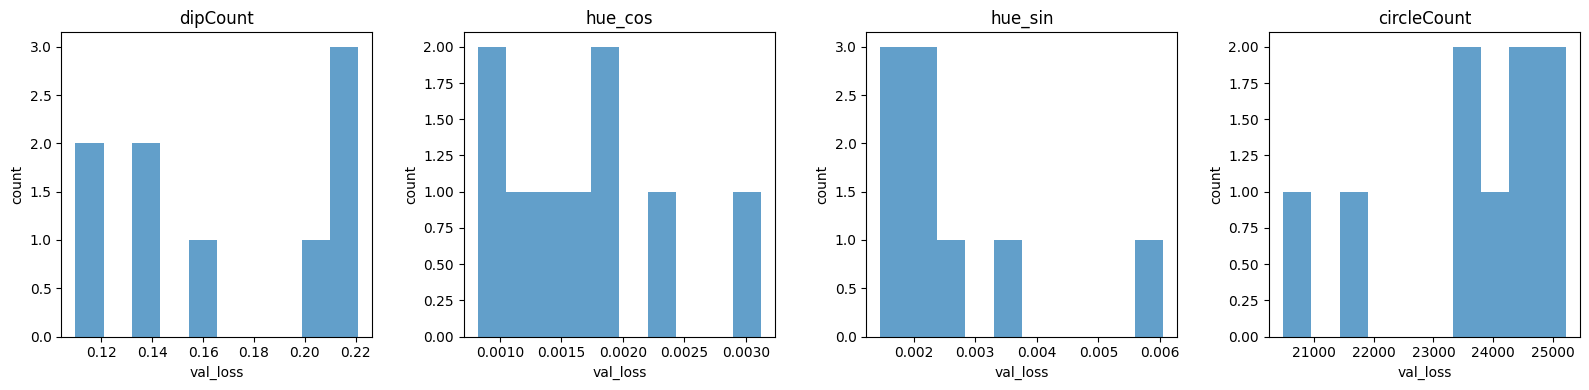

In [23]:
# === JSONを再読み込み（確認用） ===
with open(VAL_LOSS_PATH, "r") as f:
    val_losses = json.load(f)

# === 各パラメータの統計情報表示 ===
print("📊 val_losses 統計情報")
for key, losses in val_losses.items():
    arr = np.array(losses)
    print(f"- {key}: {len(losses)}件 | mean={arr.mean():.4f} | std={arr.std():.4f}")

# === ヒストグラム可視化（任意） ===
fig, axes = plt.subplots(1, len(TARGET_COLS), figsize=(4 * len(TARGET_COLS), 4))
for i, key in enumerate(TARGET_COLS):
    ax = axes[i]
    ax.hist(val_losses[key], bins=10, alpha=0.7)
    ax.set_title(key)
    ax.set_xlabel("val_loss")
    ax.set_ylabel("count")
plt.tight_layout()
plt.show()